# Задание 6


# Деревья решений и ансамбли на их основе

**Цель работы:**
* 1.Освоить принципы построения и настройки дерева решений с помощью sklearn.tree.DecisionTreeClassifier.
* 2.Познакомиться с базовыми ансамблевыми методами: Бэггинг (Bagging) и Бустинг (Boosting).
* 3.Сравнить эффективность одиночного дерева и ансамблей на практическом примере.

Набор данных содержит 13 клинико-патологических признаков, направленных на прогнозирование рецидива высокодифференцированного рака щитовидной железы. Набор данных собирался в течение 15 лет, и каждый пациент наблюдался в течение не менее 10 лет. Содержит следующие атрибуты:
* **Age** – Возраст
* **Gender** – Пол
* **Smoking** - Курение
* **Hx Smoking** – Курил ли человек
* **Hx Radiothreapy** – Лучевая терапия
* **Thyroid Function** – Функция щитовидной железы
* **Physical Examination** – Физическое обследование
* **Adenopathy** – Аденопатия
* **Pathology** – Патология
* **Focality** – Фокальность
* **Risk** – Риск
* **T** – Размер первичной опухоли
* **N** – Метастазы в лимфоузлы
* **M** – Отдаленные метастазы
* **Stage** – Этап
* **Response** – Реакция
* **Recurred** – Рецидив (целевая переменная)

# Часть первая

### 1. Импортируем необходимые библиотеки и загружаем данные

In [52]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv('Thyroid_Diff.csv')
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


### 2. Получим информацию о датасете

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

### 3. Проверяем данные на наличие пропущенных значений

In [54]:
# проверяем на пропущенные значения
print(df.isnull().sum())

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64


### 4. Изменяем категориальные признаки

In [55]:
df_copy = df.copy()
df_copy.head()


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


Преобразуем все признаки и целевую переменную к типу int64

In [56]:
from sklearn.preprocessing import LabelEncoder

labelencoder_c = LabelEncoder()

for i in ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred']:
  df_copy[i] = labelencoder_c.fit_transform(df_copy[i])

df_copy.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


In [57]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   383 non-null    int64
 1   Gender                383 non-null    int64
 2   Smoking               383 non-null    int64
 3   Hx Smoking            383 non-null    int64
 4   Hx Radiothreapy       383 non-null    int64
 5   Thyroid Function      383 non-null    int64
 6   Physical Examination  383 non-null    int64
 7   Adenopathy            383 non-null    int64
 8   Pathology             383 non-null    int64
 9   Focality              383 non-null    int64
 10  Risk                  383 non-null    int64
 11  T                     383 non-null    int64
 12  N                     383 non-null    int64
 13  M                     383 non-null    int64
 14  Stage                 383 non-null    int64
 15  Response              383 non-null    int64
 16  Recurred

### 5. Разделяем данные на признаки и целевую переменную

In [58]:
y = df_copy['Recurred']
X = df_copy.drop('Recurred', axis=1)

In [59]:
X

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,72,1,1,1,1,2,4,5,3,1,0,6,2,1,4,0
379,81,1,1,0,1,2,1,1,3,0,0,6,2,1,4,3
380,72,1,1,1,0,2,1,0,3,0,0,6,2,1,4,3
381,61,1,1,1,1,0,1,1,1,0,0,6,2,0,3,3


### 6. Первичный анализ данных

In [60]:
# Посмотрим на данные
print("Размерность признаков:", X.shape)
print("Названия признаков:", X.columns.tolist())
print("Размерность целевой переменной:", y.shape)
print("Уникальные классы:", y.unique())
print("\nПервые 5 строк признаков:")
print(X.head())

Размерность признаков: (383, 16)
Названия признаков: ['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']
Размерность целевой переменной: (383,)
Уникальные классы: [0 1]

Первые 5 строк признаков:
   Age  Gender  Smoking  Hx Smoking  Hx Radiothreapy  Thyroid Function  \
0   27       0        0           0                0                 2   
1   34       0        0           1                0                 2   
2   30       0        0           0                0                 2   
3   62       0        0           0                0                 2   
4   62       0        0           0                0                 2   

   Physical Examination  Adenopathy  Pathology  Focality  Risk  T  N  M  \
0                     3           3          2         1     2  0  0  0   
1                     1           3          2         1     2  0  0  0 

### 7. Применяем операцию нормализации для численной устойчивости

In [61]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()

X = standardizer.fit_transform(X)

In [62]:
X

array([[-0.91743929, -0.47703679, -0.38302296, ..., -0.22206996,
        -0.31442613,  0.46441951],
       [-0.45431469, -0.47703679, -0.38302296, ..., -0.22206996,
        -0.31442613, -0.62682387],
       [-0.71895732, -0.47703679, -0.38302296, ..., -0.22206996,
        -0.31442613, -0.62682387],
       ...,
       [ 2.05979025,  2.09627436,  2.61080955, ...,  4.50308536,
         4.86515272,  1.55566289],
       [ 1.33202303,  2.09627436,  2.61080955, ..., -0.22206996,
         3.57025801,  1.55566289],
       [ 1.72898697,  2.09627436,  2.61080955, ..., -0.22206996,
         3.57025801,  1.55566289]])

### 8. Разделение данных на обучающую и тестовую выборки

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print (f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (306, 16)
Размер тестовой выборки: (77, 16)


### 9. Построение и оценка базового дерева решений

In [64]:
# Создаем и обучаем модель дерева решений без настройки гиперпараметров
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [65]:
# Делаем прогнозы
y_pred_base = base_dt.predict(X_test)

In [66]:
# Оцениваем точность
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f"Точность базового дерева на тесте: {accuracy_base:.4f}")

Точность базового дерева на тесте: 0.8961


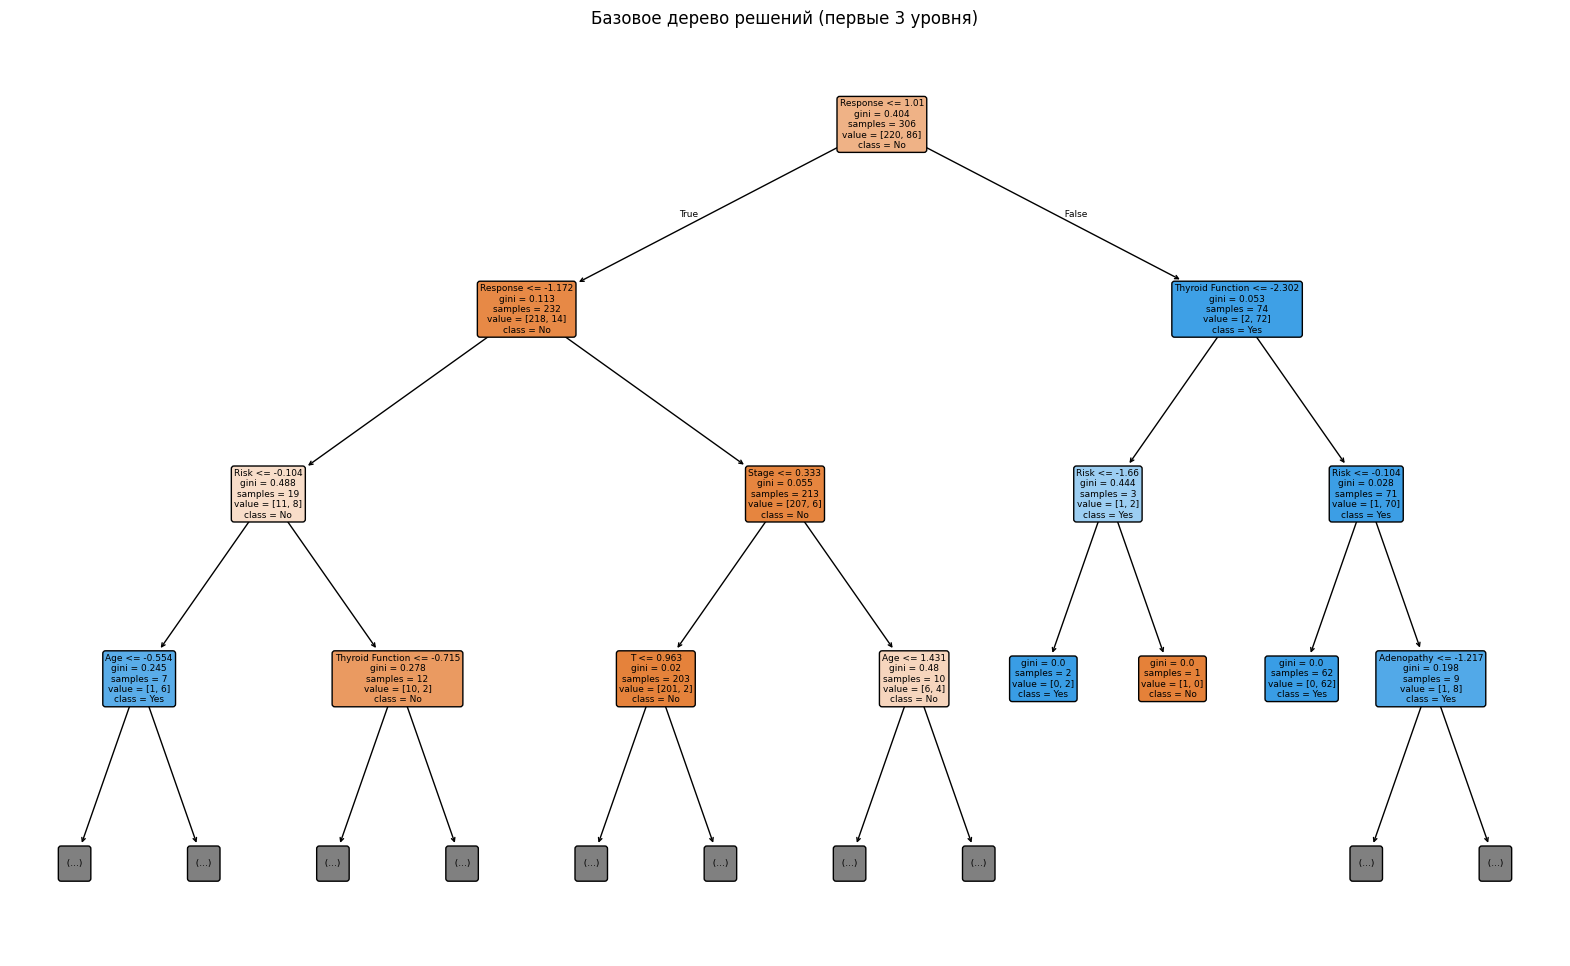

In [71]:

feature_names = df_copy.drop('Recurred', axis=1).columns.to_list()
target_names = ["No", "Yes"]

# Визуализируем дерево (будет очень большим, так как не ограничено)
plt.figure(figsize=(20, 12))
plot_tree(base_dt, filled=True, feature_names=feature_names, class_names=target_names, rounded=True, max_depth=3)

# max_depth для читаемости
plt.title("Базовое дерево решений (первые 3 уровня)")
plt.show()

### 10. Борьба с переобучением: настройка гиперпараметров

In [72]:
# Попробуем ограничить глубину дерева
tuned_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
tuned_dt.fit(X_train, y_train)

y_pred_tuned = tuned_dt.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print (f"Точность настроенного дерева (max_depth=3) на тесте: {accuracy_tuned:.4f}")

Точность настроенного дерева (max_depth=3) на тесте: 0.9740


In [73]:
# Кросс-валидация для более надежной оценки
cv_scores_base = cross_val_score(base_dt, X, y, cv=5)
cv_scores_tuned = cross_val_score(tuned_dt, X, y, cv=5)

print(f"Кросс-валидация, базовое дерево: {np.mean(cv_scores_base):.4f} (+/- {np.std(cv_scores_base) * 2:.4f})")
print(f"Кросс-валидация, настроенное дерево: {np.mean (cv_scores_tuned): .4f} (+/- {np.std(cv_scores_tuned) * 2:.4f})")

Кросс-валидация, базовое дерево: 0.8925 (+/- 0.1746)
Кросс-валидация, настроенное дерево:  0.9005 (+/- 0.1948)


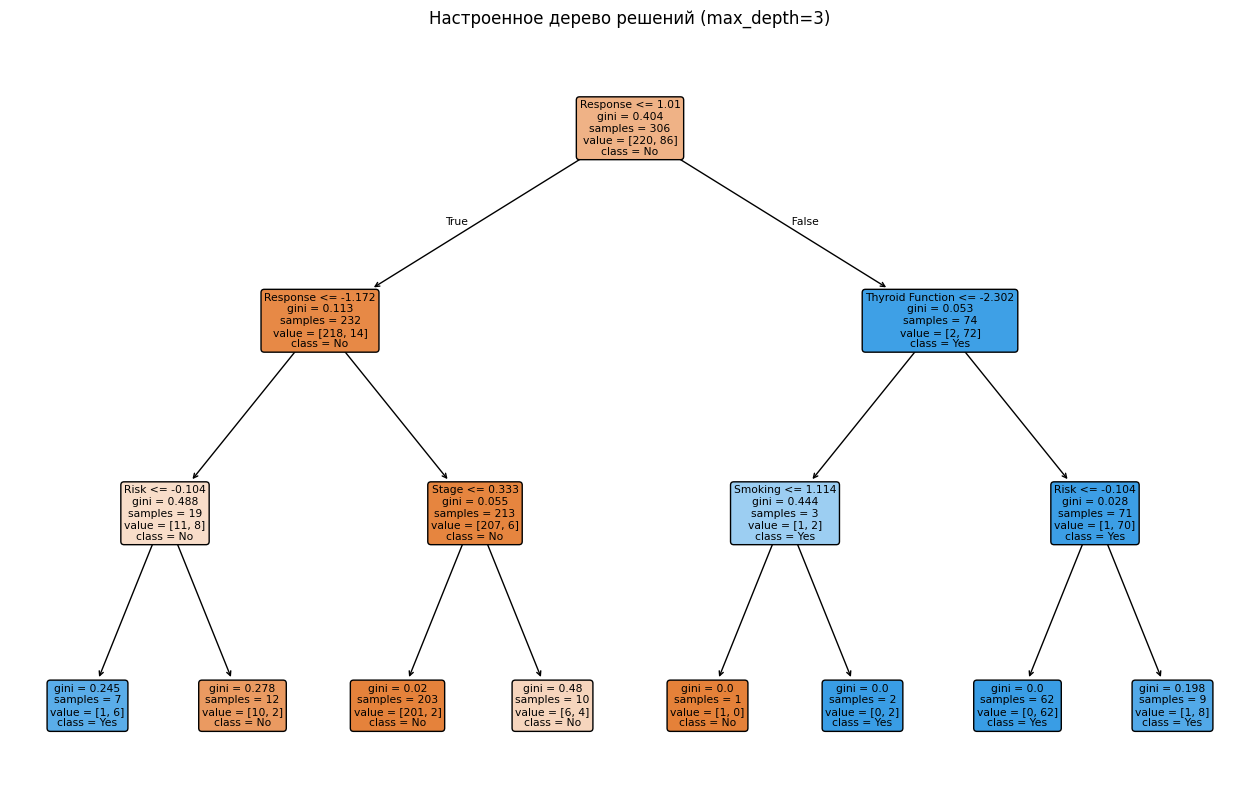

In [74]:
# Визуализируем настроенное дерево
plt.figure(figsize=(16, 10))
plot_tree(tuned_dt, filled=True,
          feature_names=feature_names, class_names=target_names, rounded=True)
plt.title("Настроенное дерево решений (max_depth=3)")
plt.show()

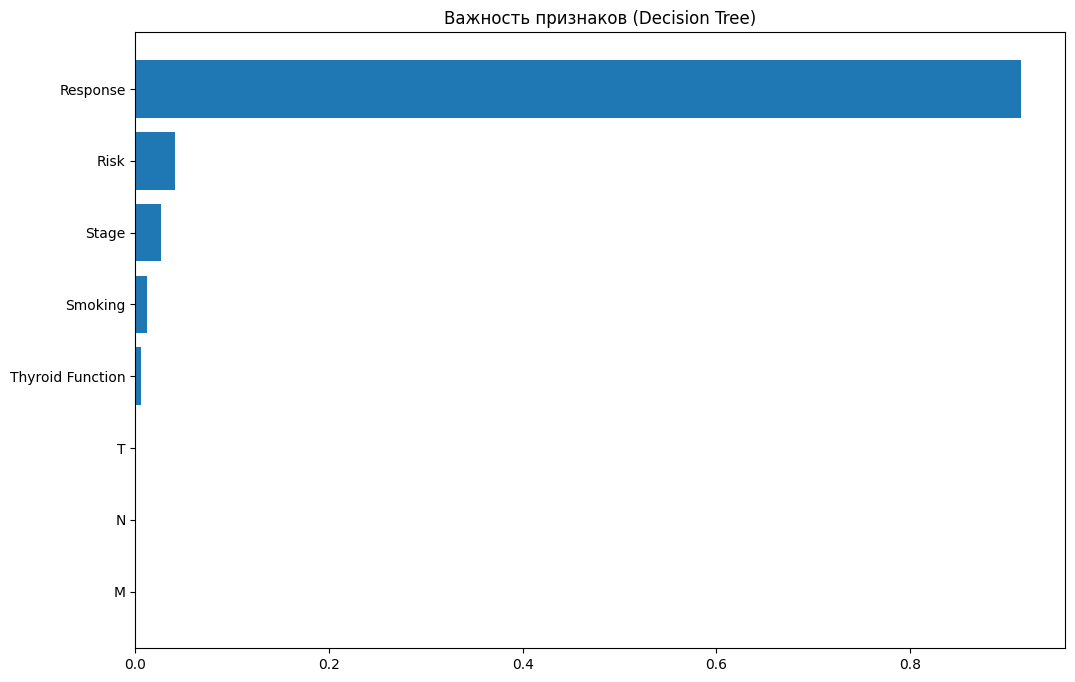

In [75]:
# Важность признаков
importances = tuned_dt.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Важность признаков (Decision Tree)")
plt.barh(range(8), importances[indices][:8]) # Топ признаков
plt.yticks(range(8), [feature_names[i] for i in indices[:8]])
plt.gca().invert_yaxis()
plt.show()

# Ансамбли: Случайный лес (Бэггинг)

In [76]:
# Создаем и обучаем случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42) # 100 деревьев
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [77]:
# Прогноз и оценка
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Точность Случайного леса на тесте: {accuracy_rf:.4f}")

Точность Случайного леса на тесте: 0.9481


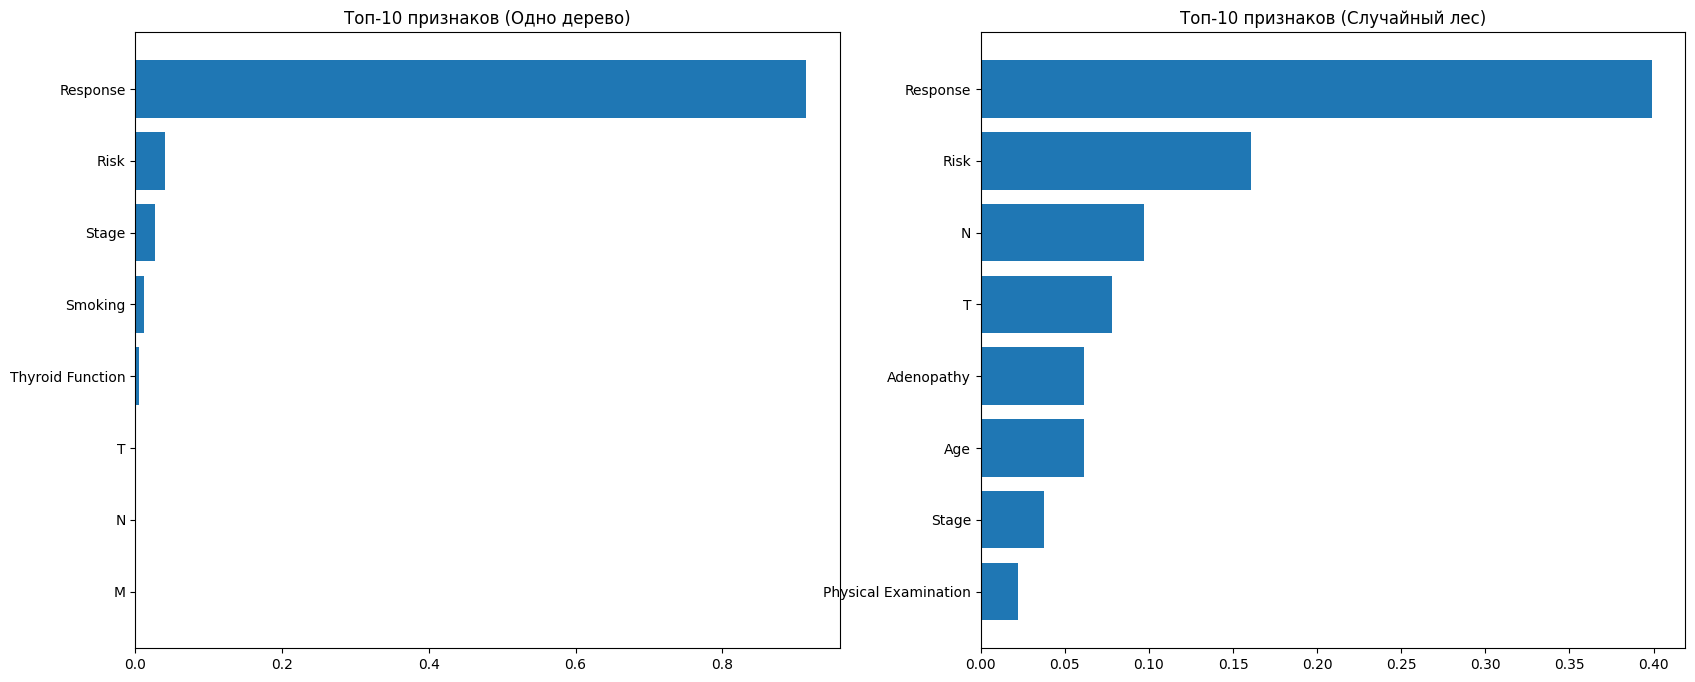

In [78]:
# Сравним важность признаков с одиночным деревом
rf_importances = rf.feature_importances_
indices_rf = np.argsort(rf_importances)[::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.barh(range(8), importances[indices][:8])
ax1.set_title("Топ-10 признаков (Одно дерево)")
ax1.set_yticks(range(8))
ax1.set_yticklabels([feature_names[i] for i in indices[:8]])
ax1.invert_yaxis()

ax2.barh(range(8), rf_importances[indices_rf][:8])
ax2.set_title("Топ-10 признаков (Случайный лес)")
ax2.set_yticks(range(8))
ax2.set_yticklabels([feature_names[i] for i in indices_rf[:8]])
ax2.invert_yaxis()
plt.show()

# Ансамбли: Градиентный бустинг (Boosting)

In [79]:
# Создаем и обучаем Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Прогноз и оценка
y_pred_gb = gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Точность Gradient Boosting на тесте: {accuracy_gb:.4f}")

Точность Gradient Boosting на тесте: 0.9610


# Сравнение всех моделей

In [80]:
# Создаем сводную таблицу результатов
models = {
'Base Decision Tree': base_dt,
'Tuned Decision Tree': tuned_dt,
'Random Forest': rf,
'Gradient Boosting': gb
}

results = {}
for name, model in models.items():
  # Обучаем на полном тренировочном наборе (если еще не обучен)
  if name not in ['Base Decision Tree', 'Tuned Decision Tree']:
    model.fit(X_train, y_train)
  # Считаем ассuracy на тренировочном и тестовом наборах
  train_acc = accuracy_score(y_train, model.predict(X_train))
  test_acc = accuracy_score(y_test, model.predict(X_test))
  results[name] = {'Train Accuracy': train_acc, 'Test Accuracy': test_acc}

                     Train Accuracy  Test Accuracy
Base Decision Tree          1.00000       0.896104
Tuned Decision Tree         0.96732       0.974026
Random Forest               1.00000       0.948052
Gradient Boosting           1.00000       0.961039


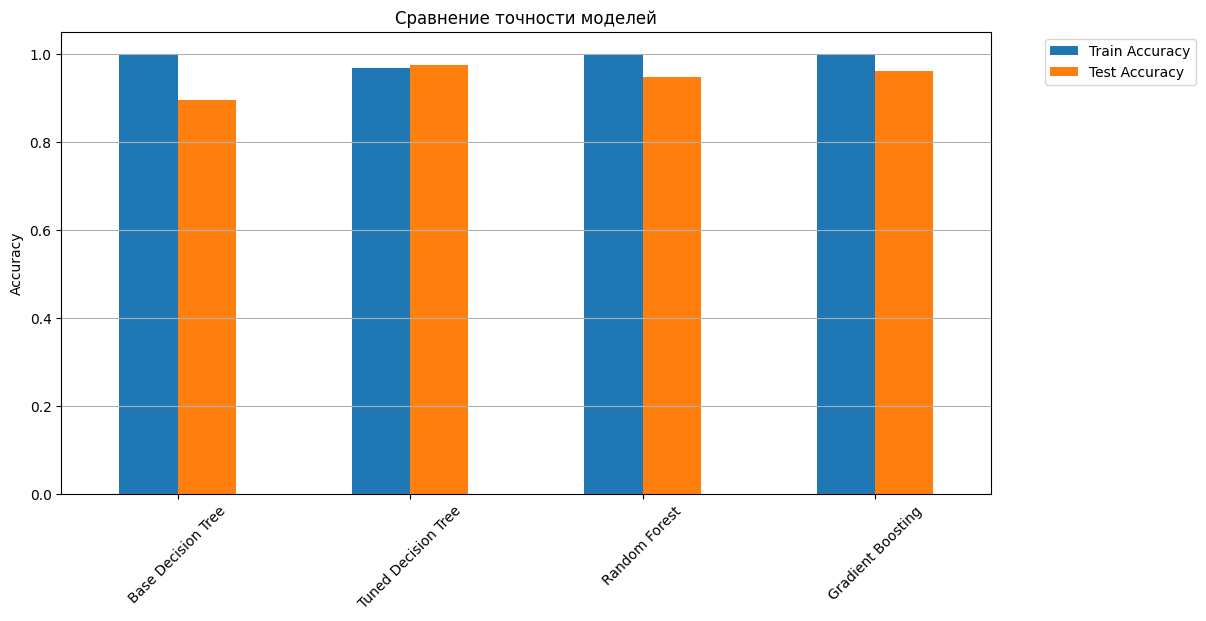

In [81]:
# Выводим результаты в виде DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Строим bar-plot для наглядности
results_df[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(12, 6))
plt.title("Cравнение точности моделей")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# Часть вторая

# Случайный лес (Random Forest)

Первые пункты повторяются из прошлой части

### 4. Разделение данных на обучающую и тестовую выборки

In [82]:
# Для воспроизводимости результатов
np.random.seed(42)

# Разделяем данные на обучающую и тестовую выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print (f"Обучающая выборка: {X_train.shape[0]} samples")
print (f"Тестовая выборка: {X_test.shape[0]} samples")

Обучающая выборка: 268 samples
Тестовая выборка: 115 samples


### 5. Создание и обучение модели Random Forest

In [83]:
# Создаем модель Random Forest
# n_estimators - количество деревьев в лесу
# random_state - для воспроизводимости результатов
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающих данных
rf_model.fit(X_train, y_train)

print("Модель Random Forest обучена!")

Модель Random Forest обучена!


### 6. Прогнозирование и оценка модели

In [84]:
# Делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(X_test)

# Оцениваем точность модели
accuracy = accuracy_score(y_test, y_pred)
print (f"Точность модели на тестовой выборке: {accuracy:.4f}")

Точность модели на тестовой выборке: 0.9826


In [85]:
# Выводим подробный отчет по классификации
print("\n" + "="*50)
print("Отчет по классификации:")
print("="*50)
print(classification_report (y_test, y_pred, target_names=target_names))


Отчет по классификации:
              precision    recall  f1-score   support

          No       0.99      0.99      0.99        83
         Yes       0.97      0.97      0.97        32

    accuracy                           0.98       115
   macro avg       0.98      0.98      0.98       115
weighted avg       0.98      0.98      0.98       115



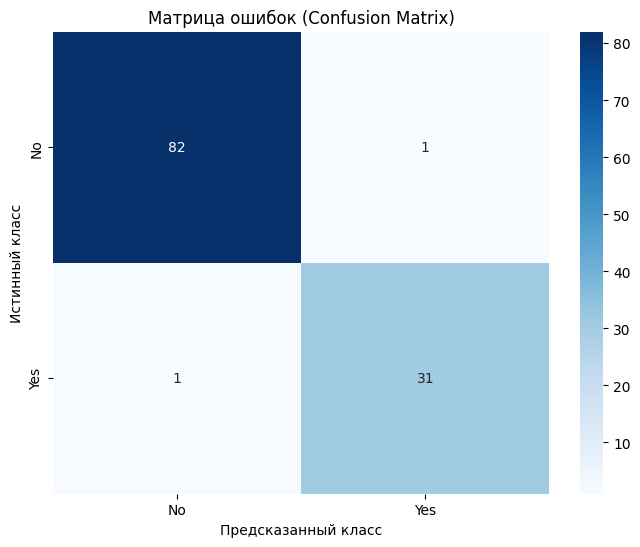

In [86]:
# Строим матрицу ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

### 7. Анализ важности признаков

Одна из ключевых особенностей Random Forest - возможность оценить важность каждого признака.

In [87]:
# Важность признаков на основе среднего уменьшения неоднородности (Gini Importance)
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
features_df = features_df.sort_values('importance', ascending=False)

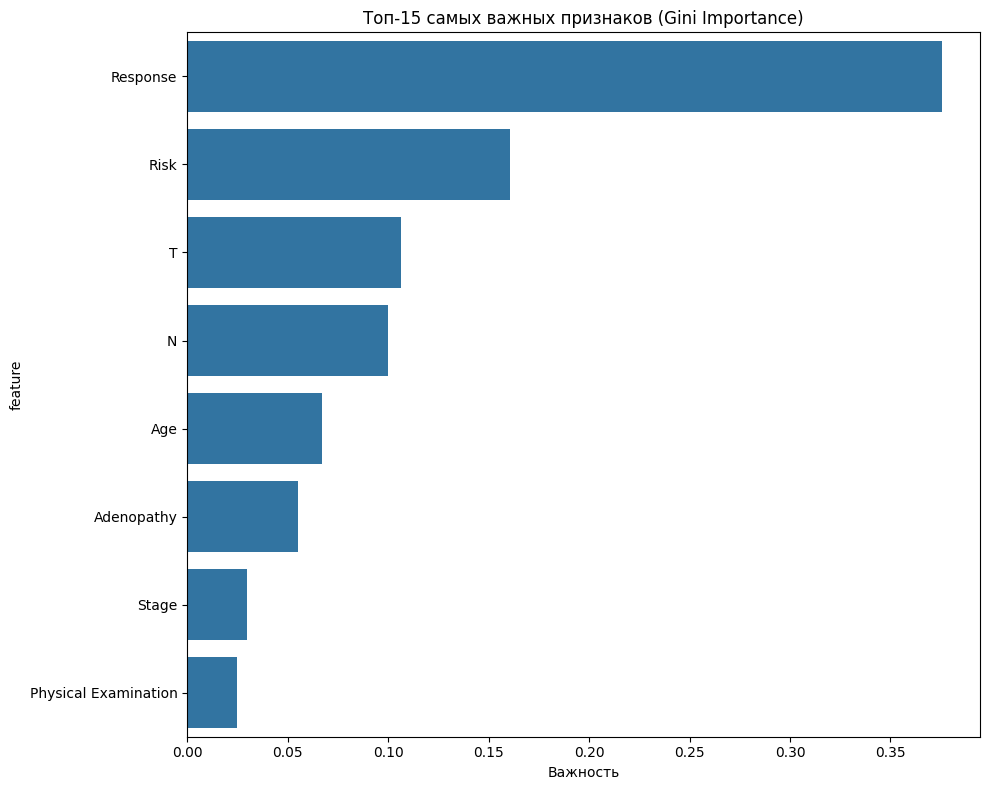

In [88]:
# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=features_df.head(8)) # Покажем топ-8 признаков
plt.title('Tоп-15 самых важных признаков (Gini Importance)')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()


In [89]:
# Вывод таблицы с важностью признаков
print("Ton-10 самых важных признаков:")
print(features_df.head(10))

Ton-10 самых важных признаков:
                 feature  importance
15              Response    0.375755
10                  Risk    0.160447
11                     T    0.106589
12                     N    0.099949
0                    Age    0.067248
7             Adenopathy    0.055295
14                 Stage    0.029864
6   Physical Examination    0.024865
1                 Gender    0.018583
9               Focality    0.016731


### 8. Подбор гиперпараметров

Для улучшения модели можно подобрать оптимальные гиперпараметры с помощью GridSearchCV

In [90]:
from sklearn.model_selection import GridSearchCV

# Определяем сетку параметров для перебора
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 10, 20],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}

In [91]:
# Создаем модель для поиска
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Запускаем поиск (может занять некоторое время)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [92]:
# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Лучшая точность при кросс-валидации: 0.9589


In [93]:
# Оцениваем лучшую модель на тестовых данных
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print (f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")

Точность улучшенной модели на тестовой выборке: 0.9826
